In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
# Load the data
file_path = "SPY_section_1.csv"
df = pd.read_csv(file_path)

# start to nov 2001 (dot com crash)
# not bad
# df = df.iloc[:2228]

# nov 01 to june 2009
# not bad
# df = df.iloc[2228:4135]

# june 2009 to april 2020
# ass
# df = df.iloc[4135:6862]

# april 2020 to most recent
# ass
# df = df.iloc[6862:]


# Convert the "Date" column to datetime
# df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')

# # Sort the data by date in ascending order
# df = df.sort_values(by="Date")

# # Get the earliest and latest dates
# earliest_date = df["Date"].min()
# latest_date = df["Date"].max()

# print("Earliest Date:", earliest_date)
# print("Latest Date:", latest_date)


In [3]:
# Adding SMA as part of the feature test
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean()
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean()
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean()

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA

df = df.dropna()

In [4]:
feature_columns = ["Open", "High", "Low", "Close", "Volume"]  
dates = df["Date"]
# if "Open" and "High" and "Low" and "Close" and "Volume" in df.columns:
#     df = df[feature_columns]


In [5]:

# scaler = StandardScaler()
# scaler = MinMaxScaler()
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Day", "Weekday", "Week", "Month", "Year"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200", "Non_Linear_Trend"]
feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend", "SMA_20", "SMA_50", "EMA_10", "EMA_50"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_200", "EMA_10"]
X = df[feature_columns]

# Split data
train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

# Initialize scaler
scaler = MinMaxScaler()
# scaler = RobustScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

# Split sequentially
X_train = X_scaled[:train_size]
X_val = X_scaled[train_size:train_size + val_size]
X_test = X_scaled[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1421, Val: 304, Test: 305


In [6]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [7]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [8]:
# # Check if CUDA is available and print the device being used
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# class Encoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(Encoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, encoding_dim)
#         )

#     def forward(self, x):
#         return self.encoder(x)

# class Decoder(nn.Module):
#     def __init__(self, encoding_dim, input_dim):
#         super(Decoder, self).__init__()
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, input_dim)
#         )

#     def forward(self, x):
#         return self.decoder(x)

    
# # Define input dimensions
# input_dim = X_train.shape[1]

# # Model file paths
# encoder_model_file = './autoencoder_trials/encoder.pth'
# decoder_model_file = './autoencoder_trials/decoder.pth'

# # Hyperparameters
# encoding_dim = 8
# learning_rate = 0.001
# epochs = 50
# batch_size = 8
# patience = 5

# # Check if the model files exist
# if os.path.exists(encoder_model_file) and os.path.exists(decoder_model_file):
#     print("Model files exist. Loading the models...")
#     encoder = Encoder(input_dim, encoding_dim).to(device)
#     decoder = Decoder(encoding_dim, input_dim).to(device)
#     encoder.load_state_dict(torch.load(encoder_model_file))
#     decoder.load_state_dict(torch.load(decoder_model_file))
# else:
#     print("Model files do not exist. Training new models...")

#     # Initialize the encoder and decoder models
#     encoder = Encoder(input_dim, encoding_dim).to(device)
#     decoder = Decoder(encoding_dim, input_dim).to(device)
#     optimizer_encoder = optim.Adam(encoder.parameters(), lr=learning_rate)
#     optimizer_decoder = optim.Adam(decoder.parameters(), lr=learning_rate)
#     criterion = nn.MSELoss()

#     # Track training loss
#     encoder_losses = []
#     decoder_losses = []

#     # Train the Encoder separately
#     encoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_train, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True, num_workers=0)
#         for i, (batch_X, _) in enumerate(dataloader):
#             batch_X = batch_X.to(device)
#             optimizer_encoder.zero_grad()
#             encoded = encoder(batch_X)
#             # Pass the encoded output through the decoder
#             decoded = decoder(encoded)
#             # Calculate loss between decoder output and original input
#             loss = criterion(decoded, batch_X)
#             loss.backward()
            
#             optimizer_encoder.step()
#             optimizer_encoder.zero_grad()
            
#             epoch_loss += loss.item()
#         avg_loss = epoch_loss / len(dataloader)
#         encoder_losses.append(avg_loss)
#         print(f"Epoch [{epoch+1}/{epochs}], Encoder Loss: {avg_loss:.4f}")

#         # Validation loss
#         encoder.eval()
#         decoder.eval()
#         with torch.no_grad():
#             val_encoded = encoder(torch.tensor(X_val, dtype=torch.float32).to(device))
#             val_decoded = decoder(val_encoded)
#             val_loss = criterion(val_decoded, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
#         print(f"Validation Loss: {val_loss:.4f}")

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping triggered.")
#                 break

#     # Train the Decoder separately
#     encoded_train = encoder(torch.tensor(X_train, dtype=torch.float32).to(device)).detach()
#     decoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(encoded_train, torch.tensor(X_train, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True, num_workers=0)
#         for i, (batch_X, batch_y) in enumerate(dataloader):
#             batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#             optimizer_decoder.zero_grad()
#             outputs = decoder(batch_X)
#             # Calculate loss between decoder output and original input
#             loss = criterion(outputs, batch_y)
#             loss.backward()
            
#             optimizer_decoder.step()
#             optimizer_decoder.zero_grad()
            
#             epoch_loss += loss.item()
#         avg_loss = epoch_loss / len(dataloader)
#         decoder_losses.append(avg_loss)
#         print(f"Epoch [{epoch+1}/{epochs}], Decoder Loss: {avg_loss:.4f}")

#         # Validation loss
#         decoder.eval()
#         with torch.no_grad():
#             val_outputs = decoder(encoded_train)
#             val_loss = criterion(val_outputs, torch.tensor(X_train, dtype=torch.float32).to(device)).item()
#         print(f"Validation Loss: {val_loss:.4f}")

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             print("Early stopping counter:", patience_counter)
#             if patience_counter >= patience:
#                 print("Early stopping triggered.")
#                 break

#     # Save the trained models
#     os.makedirs('./autoencoder_trials', exist_ok=True)
#     # torch.save(encoder.state_dict(), encoder_model_file)
#     # torch.save(decoder.state_dict(), decoder_model_file)
#     print("Models trained and saved.")

# # Combine Encoder and Decoder to form the Autoencoder
# class Autoencoder(nn.Module):
#     def __init__(self, encoder, decoder):
#         super(Autoencoder, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

# autoencoder = Autoencoder(encoder, decoder).to(device)
# autoencoder.eval()

# # Calculate reconstruction error on the test set
# with torch.no_grad():
#     reconstructed_test = autoencoder(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# # Calculate Mean Squared Error (MSE)
# mse = np.mean((X_test - reconstructed_test) ** 2)
# print(f'Mean Squared Error (MSE): {mse}')

# # Calculate Mean Absolute Error (MAE)
# mae = np.mean(np.abs(X_test - reconstructed_test))
# print(f'Mean Absolute Error (MAE): {mae}')

# # Calculate Reconstruction Error Percentage
# # reconstruction_error = np.mean(np.square(X_test - reconstructed_test), axis=1)
# # reconstruction_error_percentage = np.mean(reconstruction_error) * 100
# # print(f'Reconstruction Error Percentage: {reconstruction_error_percentage}')

# reconstruction_error_percentage = (
#     np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
# )
# reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
# print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean}')

# def calculate_index_error_percentage(index, X, reconstructed_X):
#     print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)     


In [9]:
# # import os
# # import torch
# # import torch.nn as nn
# # import torch.optim as optim
# # import numpy as np
# # from torch.utils.data import DataLoader, TensorDataset

# # # Check if CUDA is available
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # print(f"Using device: {device}")

# # # Define Encoder
# # class Encoder(nn.Module):
# #     def __init__(self, input_dim, encoding_dim, dropout_rate):
# #         super(Encoder, self).__init__()
# #         self.encoder = nn.Sequential(
# #             nn.Linear(input_dim, 128),
# #             nn.ReLU(),
# #             nn.Dropout(dropout_rate),
# #             nn.Linear(128, 64),
# #             nn.ReLU(),
# #             nn.Dropout(dropout_rate),
# #             nn.Linear(64, encoding_dim)
# #         )

# #     def forward(self, x):
# #         return self.encoder(x)

# # # Define Decoder
# # class Decoder(nn.Module):
# #     def __init__(self, encoding_dim, input_dim, dropout_rate):
# #         super(Decoder, self).__init__()
# #         self.decoder = nn.Sequential(
# #             nn.Linear(encoding_dim, 64),
# #             nn.ReLU(),
# #             nn.Dropout(dropout_rate),
# #             nn.Linear(64, 128),
# #             nn.ReLU(),
# #             nn.Dropout(dropout_rate),
# #             nn.Linear(128, input_dim)
# #         )

# #     def forward(self, x):
# #         return self.decoder(x)

# # def relative_euclidean_error(X, X_reconstructed):
# #     return np.linalg.norm(X - X_reconstructed, axis=1) / np.linalg.norm(X, axis=1)

# # class RelativeEuclideanError(nn.Module):
# #     def forward(self, y_true, y_pred):
# #         return torch.mean(torch.norm(y_true - y_pred, dim=1) / torch.norm(y_true, dim=1))

# # # Define input dimensions
# # input_dim = X_train.shape[1]

# # # Model file paths
# # encoder_model_file = './autoencoder_trials/encoder.pth'
# # decoder_model_file = './autoencoder_trials/decoder.pth'

# # # Hyperparameters
# # encoding_dim = 5
# # learning_rate = 0.0001
# # dropout_rate = 0.0
# # epochs = 750
# # batch_size = 16
# # patience = 30

# # # Initialize models
# # encoder = Encoder(input_dim, encoding_dim, dropout_rate).to(device)
# # decoder = Decoder(encoding_dim, input_dim, dropout_rate).to(device)

# # # Define optimizers and loss function
# # optimizer_encoder = optim.Adam(encoder.parameters(), lr=learning_rate)
# # optimizer_decoder = optim.Adam(decoder.parameters(), lr=learning_rate)
# # # criterion = nn.MSELoss()
# # criterion = RelativeEuclideanError()
# # #use MAE
# # # criterion = nn.L1Loss()

# # # Add Gaussian noise to encoded representations to avoid overfitting
# # def add_noise(encoded, noise_factor=0.01):
# #     return encoded + noise_factor * torch.randn_like(encoded)

# # # Train Encoder
# # def train_encoder():
# #     print("Training Encoder...")
# #     encoder.train()
# #     best_val_loss = float('inf')
# #     patience_counter = 0
# #     # clip_value = 1

# #     for epoch in range(epochs):
# #         epoch_loss = 0
# #         dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), 
# #                                               torch.tensor(X_train, dtype=torch.float32).to(device)), 
# #                                 batch_size=batch_size, shuffle=True, num_workers=0)

# #         for batch_X, _ in dataloader:
# #             batch_X = batch_X.to(device)
# #             optimizer_encoder.zero_grad()
# #             encoded = encoder(batch_X)
# #             decoded = decoder(encoded)
# #             loss = criterion(decoded, batch_X)
# #             loss.backward()
            
# #             # torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=clip_value)  # Option 1
# #             # torch.nn.utils.clip_grad_value_(encoder.parameters(), clip_value=clip_value)  # Option 2

# #             optimizer_encoder.step()
# #             epoch_loss += loss.item()

# #         avg_loss = epoch_loss / len(dataloader)
# #         print(f"Epoch [{epoch+1}/{epochs}], Encoder Loss: {avg_loss:.4f}")

# #         # Validation loss
# #         encoder.eval()
# #         decoder.eval()
# #         with torch.no_grad():
# #             val_encoded = encoder(torch.tensor(X_val, dtype=torch.float32).to(device))
# #             val_decoded = decoder(val_encoded)
# #             val_loss = criterion(val_decoded, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
# #         print(f"Validation Loss: {val_loss:.4f}")

# #         # Early stopping
# #         if val_loss < best_val_loss:
# #             best_val_loss = val_loss
# #             patience_counter = 0
# #             torch.save(encoder.state_dict(), encoder_model_file)  # Save best model
# #         else:
# #             patience_counter += 1
# #             print("Early stopping counter:", patience_counter)
# #             if patience_counter >= patience:
# #                 print("Early stopping triggered for encoder.")
# #                 break

# # # Train Decoder
# # def train_decoder():
# #     print("Training Decoder...")
# #     encoder.eval()
# #     encoded_train = encoder(torch.tensor(X_train, dtype=torch.float32).to(device)).detach()

# #     decoder.train()
# #     best_val_loss = float('inf')
# #     patience_counter = 0
# #     # clip_value = 1

# #     for epoch in range(epochs):
# #         epoch_loss = 0
# #         dataloader = DataLoader(TensorDataset(encoded_train, torch.tensor(X_train, dtype=torch.float32).to(device)), 
# #                                 batch_size=batch_size, shuffle=True, num_workers=0)

# #         for batch_X, batch_y in dataloader:
# #             batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
# #             # Add Gaussian noise
# #             noisy_batch_X = add_noise(batch_X)

# #             optimizer_decoder.zero_grad()
# #             outputs = decoder(noisy_batch_X)
# #             loss = criterion(outputs, batch_y)
# #             loss.backward()
            
# #             # torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=clip_value)  # Option 1
# #             # torch.nn.utils.clip_grad_value_(decoder.parameters(), clip_value=clip_value)  # Option 2
            
# #             optimizer_decoder.step()
            
# #             epoch_loss += loss.item()

# #         avg_loss = epoch_loss / len(dataloader)
# #         print(f"Epoch [{epoch+1}/{epochs}], Decoder Loss: {avg_loss:.4f}")

# #         # Validation loss
# #         decoder.eval()
# #         with torch.no_grad():
# #             val_encoded = encoder(torch.tensor(X_val, dtype=torch.float32).to(device))
# #             val_decoded = decoder(val_encoded)
# #             val_loss = criterion(val_decoded, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
# #         print(f"Validation Loss: {val_loss:.4f}")

# #         # Early stopping
# #         if val_loss < best_val_loss:
# #             best_val_loss = val_loss
# #             patience_counter = 0
# #             torch.save(decoder.state_dict(), decoder_model_file)  # Save best model
# #         else:
# #             patience_counter += 1
# #             print("Early stopping counter:", patience_counter)
# #             if patience_counter >= patience:
# #                 print("Early stopping triggered for decoder.")
# #                 break

# # # Train models if files do not exist
# # if os.path.exists(encoder_model_file) and os.path.exists(decoder_model_file):
# #     print("Model files exist. Loading the models...")
# #     encoder.load_state_dict(torch.load(encoder_model_file))
# #     decoder.load_state_dict(torch.load(decoder_model_file))
# # else:
# #     os.makedirs('./autoencoder_trials', exist_ok=True)
# #     train_encoder()
# #     train_decoder()

# # # Combine Encoder and Decoder to form the Autoencoder
# # class Autoencoder(nn.Module):
# #     def __init__(self, encoder, decoder):
# #         super(Autoencoder, self).__init__()
# #         self.encoder = encoder
# #         self.decoder = decoder

# #     def forward(self, x):
# #         encoded = self.encoder(x)
# #         decoded = self.decoder(encoded)
# #         return decoded

# # # Load trained models
# # encoder.load_state_dict(torch.load(encoder_model_file))
# # decoder.load_state_dict(torch.load(decoder_model_file))
# # autoencoder = Autoencoder(encoder, decoder).to(device)
# # autoencoder.eval()

# # # Calculate reconstruction error on the test set
# # with torch.no_grad():
# #     reconstructed_test = autoencoder(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# # # Calculate Mean Squared Error (MSE)
# # mse = np.mean((X_test - reconstructed_test) ** 2)
# # print(f'Mean Squared Error (MSE): {mse}')

# # # Calculate Mean Absolute Error (MAE)
# # mae = np.mean(np.abs(X_test - reconstructed_test))
# # print(f'Mean Absolute Error (MAE): {mae}')

# # # Calculate Reconstruction Error Percentage
# # reconstruction_error_percentage = (
# #     np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
# # )
# # reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
# # print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean:.4f}%')

# # def calculate_index_error_percentage(index, X, reconstructed_X):
# #     print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)  


# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from torch.utils.data import DataLoader, TensorDataset

# # Check if CUDA is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Define Autoencoder
# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim, dropout_rate):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(64, encoding_dim)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(128, input_dim)
#         )
    
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

# # Define Relative Euclidean Error Loss
# class RelativeEuclideanError(nn.Module):
#     def __init__(self, epsilon=1e-8):
#         super(RelativeEuclideanError, self).__init__()
#         self.epsilon = epsilon

#     def forward(self, y_true, y_pred):
#         numerator = torch.norm(y_true - y_pred, dim=1)
#         denominator = torch.norm(y_true, dim=1) + self.epsilon
#         return torch.mean(numerator / denominator)

# # Define input dimensions
# input_dim = X_train.shape[1]

# # Model file path
# autoencoder_model_file = './autoencoder_trials/autoencoder.pth'

# # Hyperparameters
# encoding_dim = 5
# learning_rate = 0.0005
# dropout_rate = 0.3
# epochs = 750
# batch_size = 16
# patience = 40

# # Initialize model
# autoencoder = Autoencoder(input_dim, encoding_dim, dropout_rate).to(device)
# optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
# # criterion = RelativeEuclideanError()
# criterion = nn.MSELoss()

# # Train Autoencoder
# def train_autoencoder():
#     print("Training Autoencoder...")
#     autoencoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0

#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), 
#                                               torch.tensor(X_train, dtype=torch.float32).to(device)), 
#                                 batch_size=batch_size, shuffle=True, num_workers=0)

#         for batch_X, _ in dataloader:
#             batch_X = batch_X.to(device)
#             optimizer.zero_grad()
#             outputs = autoencoder(batch_X)
#             loss = criterion(outputs, batch_X)
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(dataloader)
#         print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

#         # Validation loss
#         autoencoder.eval()
#         with torch.no_grad():
#             val_outputs = autoencoder(torch.tensor(X_val, dtype=torch.float32).to(device))
#             val_loss = criterion(val_outputs, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
            
#             # calculate Relative Euclidean Error
#             relative_error = np.mean(np.abs(X_val - val_outputs.cpu().numpy()) / (np.abs(X_val) + 1e-8), axis=1) * 100
#             relative_error_mean = np.mean(relative_error)
            
#             combined_metric = 0.8 * val_loss + 0.2 * relative_error_mean
            
#         print(f"Validation Loss: {combined_metric:.4f}")

#         # Early stopping
#         if combined_metric < best_val_loss:
#             best_val_loss = combined_metric
#             patience_counter = 0
#             torch.save(autoencoder.state_dict(), autoencoder_model_file)
#         else:
#             patience_counter += 1
#             print("Early stopping counter:", patience_counter)
#             if patience_counter >= patience:
#                 print("Early stopping triggered.")
#                 break

# # Train model if file does not exist
# if os.path.exists(autoencoder_model_file):
#     print("Model file exists. Loading the model...")
#     autoencoder.load_state_dict(torch.load(autoencoder_model_file))
# else:
#     os.makedirs('./autoencoder_trials', exist_ok=True)
#     train_autoencoder()

# # Evaluate Autoencoder
# autoencoder.eval()
# with torch.no_grad():
#     reconstructed_test = autoencoder(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# # Calculate evaluation metrics
# mse = np.mean((X_test - reconstructed_test) ** 2)
# print(f'Mean Squared Error (MSE): {mse}')

# mae = np.mean(np.abs(X_test - reconstructed_test))
# print(f'Mean Absolute Error (MAE): {mae}')

# reconstruction_error_percentage = (
#     np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
# )
# reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
# print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean:.4f}%')

# def calculate_index_error_percentage(index, X, reconstructed_X):
#     print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)



In [10]:
# # number of points with error greater than average
# np.sum(reconstruction_error_percentage > reconstruction_error_percentage_mean)

In [11]:
# # plot line graph of price for entire df, price column is df['Close']
# last_15_percent_index = int(len(df) * 0.85)
# last_30_percent_index = int(len(df) * 0.70)

# plt.figure(figsize=(14, 7))
# plt.plot(df['Close'], label='Train', color='blue')
# plt.plot(df['Close'].iloc[last_30_percent_index:last_15_percent_index], label='Val', color='green')
# plt.plot(df['Close'].iloc[last_15_percent_index:], label='Test', color='red')
# plt.title('Close Price History')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()

In [12]:
# #   scatter graph to plot all errors, dont need to rearragne points
# plt.figure(figsize=(14, 7))
# plt.scatter(range(len(reconstruction_error_percentage)), reconstruction_error_percentage, color='blue')
# plt.ylim(0, 200)
# plt.title('Reconstruction Error Percentage')
# plt.xlabel('Data Point')
# plt.ylabel('Error Percentage')
# plt.legend()
# plt.show()



In [13]:
# # error count frequency per range
# error_ranges = [0, 1, 2, 5, 10, 20, 50, 100, 200]
# error_counts = np.zeros(len(error_ranges) - 1)
# for i in range(len(error_ranges) - 1):
#     error_counts[i] = np.sum((reconstruction_error_percentage > error_ranges[i]) & (reconstruction_error_percentage <= error_ranges[i + 1]))

# # print with descriptino
# for i in range(len(error_ranges) - 1):
#     print(f'Error percentage between {error_ranges[i]} and {error_ranges[i + 1]}: {error_counts[i]}')

In [14]:
# # get cosine similarity
# from sklearn.metrics.pairwise import cosine_similarity
# cosine_similarities  = np.diag(cosine_similarity(X_test, reconstructed_test))

# # get some statistics on the cosine similarities
# cosine_similarities_mean = np.mean(cosine_similarities)
# cosine_similarities_std = np.std(cosine_similarities)
# cosine_similarities_min = np.min(cosine_similarities)
# cosine_similarities_max = np.max(cosine_similarities)

# print(f'Cosine Similarity Mean: {cosine_similarities_mean}')
# print(f'Cosine Similarity Std: {cosine_similarities_std}')
# print(f'Cosine Similarity Min: {cosine_similarities_min}')
# print(f'Cosine Similarity Max: {cosine_similarities_max}')


In [15]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Combine original and reconstructed vectors
# X_combined = np.vstack([X_test, reconstructed_test])
# labels = ["Original"] * len(X_test) + ["Reconstructed"] * len(reconstructed_test)

# # Apply t-SNE
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X_combined)

# # Plot
# plt.figure(figsize=(12, 6))
# plt.scatter(X_tsne[:len(X_test), 0], X_tsne[:len(X_test), 1], label="Original", alpha=0.5)
# plt.scatter(X_tsne[len(X_test):, 0], X_tsne[len(X_test):, 1], label="Reconstructed", alpha=0.5)
# plt.legend()
# plt.title("t-SNE Visualization of Original vs. Reconstructed Data")
# plt.show()


In [16]:
# from sklearn.decomposition import PCA

# X_combined = np.vstack([X_test, reconstructed_test])

# # Apply PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_combined)

# # Plot
# plt.figure(figsize=(12, 6))
# plt.scatter(X_pca[:len(X_test), 0], X_pca[:len(X_test), 1], label="Original", alpha=0.5)
# plt.scatter(X_pca[len(X_test):, 0], X_pca[len(X_test):, 1], label="Reconstructed", alpha=0.5)
# plt.legend()
# plt.title("PCA Projection of Original vs. Reconstructed Data")
# plt.show()


In [17]:
# from numpy.linalg import norm

# euclidean_dist = np.mean([norm(X_test[i] - reconstructed_test[i]) for i in range(len(X_test))])
# print(f"Average Euclidean Distance: {euclidean_dist:.4f}")

# relative_error = euclidean_dist / np.mean(np.linalg.norm(X_test, axis=1))
# print(f"Relative Euclidean Error: {relative_error:.4f}")



In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from numpy.linalg import norm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define input dimensions
input_dim = X_train.shape[1]

# Hyperparameters
encoding_dim = 5
learning_rate = 0.0005
dropout_rate = 0.3
epochs = 750
batch_size = 16
patience = 40

# Create directory for saving models
save_dir = "./autoencoder_models"
os.makedirs(save_dir, exist_ok=True)

# Training function
def train_autoencoder(trial):
    autoencoder = Autoencoder(input_dim, encoding_dim, dropout_rate).to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    
    for epoch in range(epochs):
        epoch_loss = 0
        dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True)

        for batch_X in dataloader:
            batch_X = batch_X[0]
            optimizer.zero_grad()
            outputs = autoencoder(batch_X)
            loss = criterion(outputs, batch_X)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        
        # Validation
        autoencoder.eval()
        with torch.no_grad():
            val_outputs = autoencoder(torch.tensor(X_val, dtype=torch.float32).to(device))
            mse_loss = criterion(val_outputs, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
            ree = np.mean(np.linalg.norm(X_val - val_outputs.cpu().numpy(), axis=1) / np.linalg.norm(X_val, axis=1))
            combined_metric = 0.8 * mse_loss + 0.2 * ree
        
        print(f"Epoch [{epoch+1}/{epochs}], Combined Loss: {combined_metric:.4f}")
        
        # Early stopping
        if combined_metric < best_val_loss:
            best_val_loss = combined_metric
            patience_counter = 0
            best_model = autoencoder.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    
    # Save best model for this trial
    model_path = os.path.join(save_dir, f"autoencoder_trial_{trial+1}.pth")
    torch.save(best_model, model_path)
    print(f"Model saved: {model_path}")
    
    return best_model

# Run 10 trials
num_trials = 10
metrics = []
error_percentages = []

t_sne_results = []
pca_results = []

for trial in range(num_trials):
    print(f"Starting trial {trial+1}...")
    best_model = train_autoencoder(trial)
    autoencoder = Autoencoder(input_dim, encoding_dim, dropout_rate).to(device)
    autoencoder.load_state_dict(best_model)
    autoencoder.eval()
    
    with torch.no_grad():
        reconstructed_test = autoencoder(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
    
    mse = np.mean((X_test - reconstructed_test) ** 2)
    mae = np.mean(np.abs(X_test - reconstructed_test))
    ree = np.mean(np.linalg.norm(X_test - reconstructed_test, axis=1) / np.linalg.norm(X_test, axis=1))
    euclidean_dist = np.mean([norm(X_test[i] - reconstructed_test[i]) for i in range(len(X_test))])
    
    print(f'Trial {trial+1} - MSE: {mse:.4f}, MAE: {mae:.4f}, REE: {ree:.4f}, Euclidean Distance: {euclidean_dist:.4f}')
    metrics.append([mse, mae, ree, euclidean_dist])
    
    # Reconstruction Error Percentage
    reconstruction_error_percentage = (
        np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
    )
    error_percentages.append(reconstruction_error_percentage)
    
    # t-SNE
    X_combined = np.vstack([X_test, reconstructed_test])
    labels = ["Original"] * len(X_test) + ["Reconstructed"] * len(reconstructed_test)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    t_sne_results.append(tsne.fit_transform(X_combined))
    
    # PCA
    pca = PCA(n_components=2)
    pca_results.append(pca.fit_transform(X_combined))


Using device: cuda
Starting trial 1...
Epoch [1/750], Combined Loss: 0.0451
Epoch [2/750], Combined Loss: 0.0197
Epoch [3/750], Combined Loss: 0.0178
Epoch [4/750], Combined Loss: 0.0166
Epoch [5/750], Combined Loss: 0.0158
Epoch [6/750], Combined Loss: 0.0153
Epoch [7/750], Combined Loss: 0.0161
Epoch [8/750], Combined Loss: 0.0158
Epoch [9/750], Combined Loss: 0.0162
Epoch [10/750], Combined Loss: 0.0156
Epoch [11/750], Combined Loss: 0.0156
Epoch [12/750], Combined Loss: 0.0130
Epoch [13/750], Combined Loss: 0.0101
Epoch [14/750], Combined Loss: 0.0106
Epoch [15/750], Combined Loss: 0.0110
Epoch [16/750], Combined Loss: 0.0119
Epoch [17/750], Combined Loss: 0.0097
Epoch [18/750], Combined Loss: 0.0098
Epoch [19/750], Combined Loss: 0.0117
Epoch [20/750], Combined Loss: 0.0093
Epoch [21/750], Combined Loss: 0.0108
Epoch [22/750], Combined Loss: 0.0116
Epoch [23/750], Combined Loss: 0.0115
Epoch [24/750], Combined Loss: 0.0116
Epoch [25/750], Combined Loss: 0.0124
Epoch [26/750], Comb

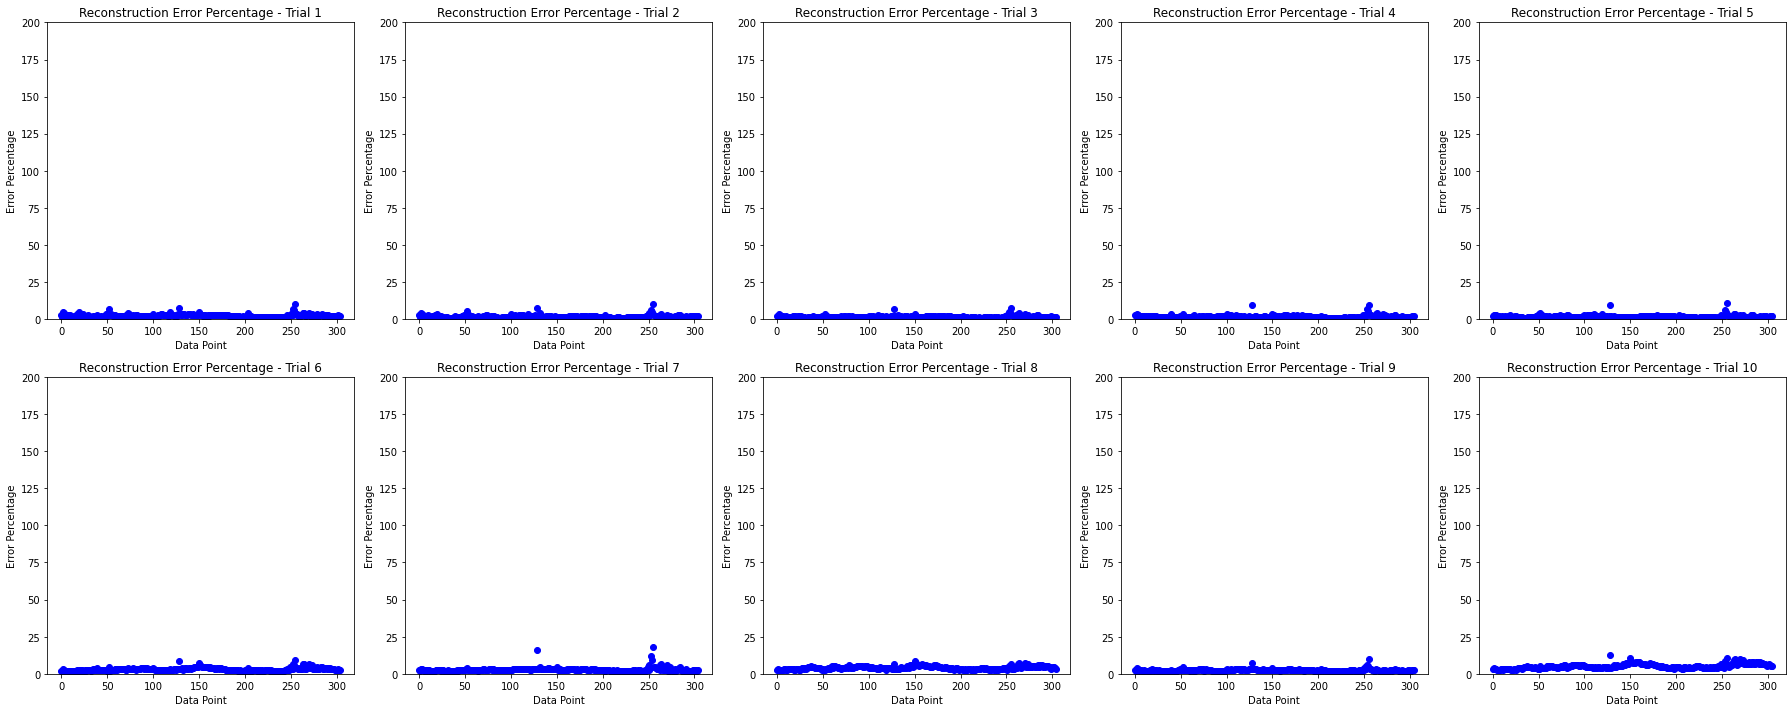

In [19]:
num_trials = 10

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

# Plot Reconstruction Error Percentage
for trial in range(num_trials):
    ax = axes[trial]
    ax.scatter(range(len(error_percentages[trial])), error_percentages[trial], color='blue')
    ax.set_ylim(0, 200)
    ax.set_title(f'Reconstruction Error Percentage - Trial {trial+1}')
    ax.set_xlabel('Data Point')
    ax.set_ylabel('Error Percentage')

# Adjust layout
plt.tight_layout()
plt.show()

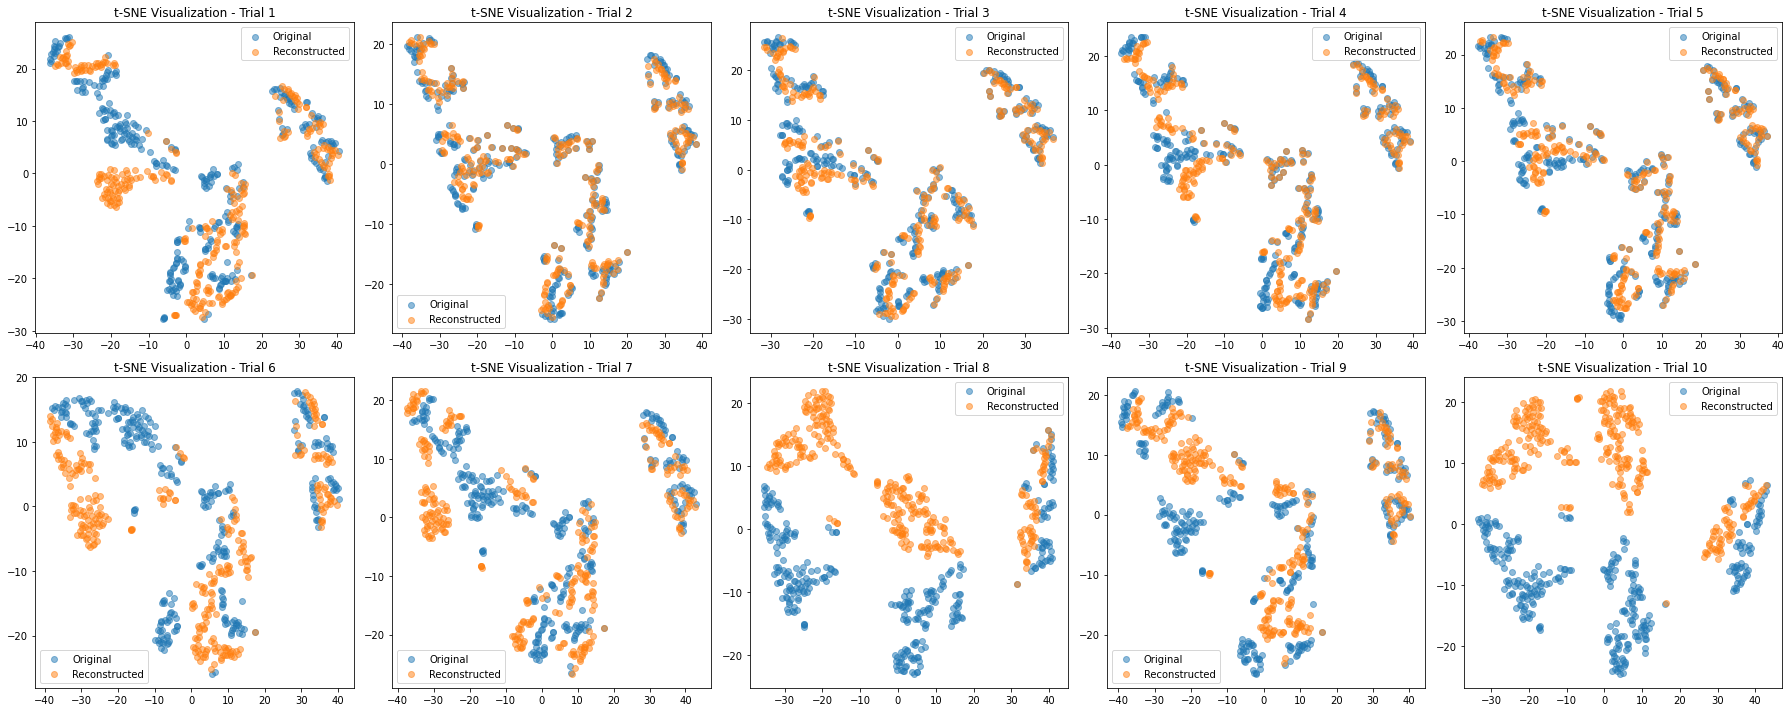

In [20]:
num_trials = 10

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

# Plot t-SNE Visualization
for trial in range(num_trials):
    ax = axes[trial]
    ax.scatter(t_sne_results[trial][:len(X_test), 0], t_sne_results[trial][:len(X_test), 1], label="Original", alpha=0.5)
    ax.scatter(t_sne_results[trial][len(X_test):, 0], t_sne_results[trial][len(X_test):, 1], label="Reconstructed", alpha=0.5)
    ax.legend()
    ax.set_title(f't-SNE Visualization - Trial {trial+1}')

# Adjust layout
plt.tight_layout()
plt.show()

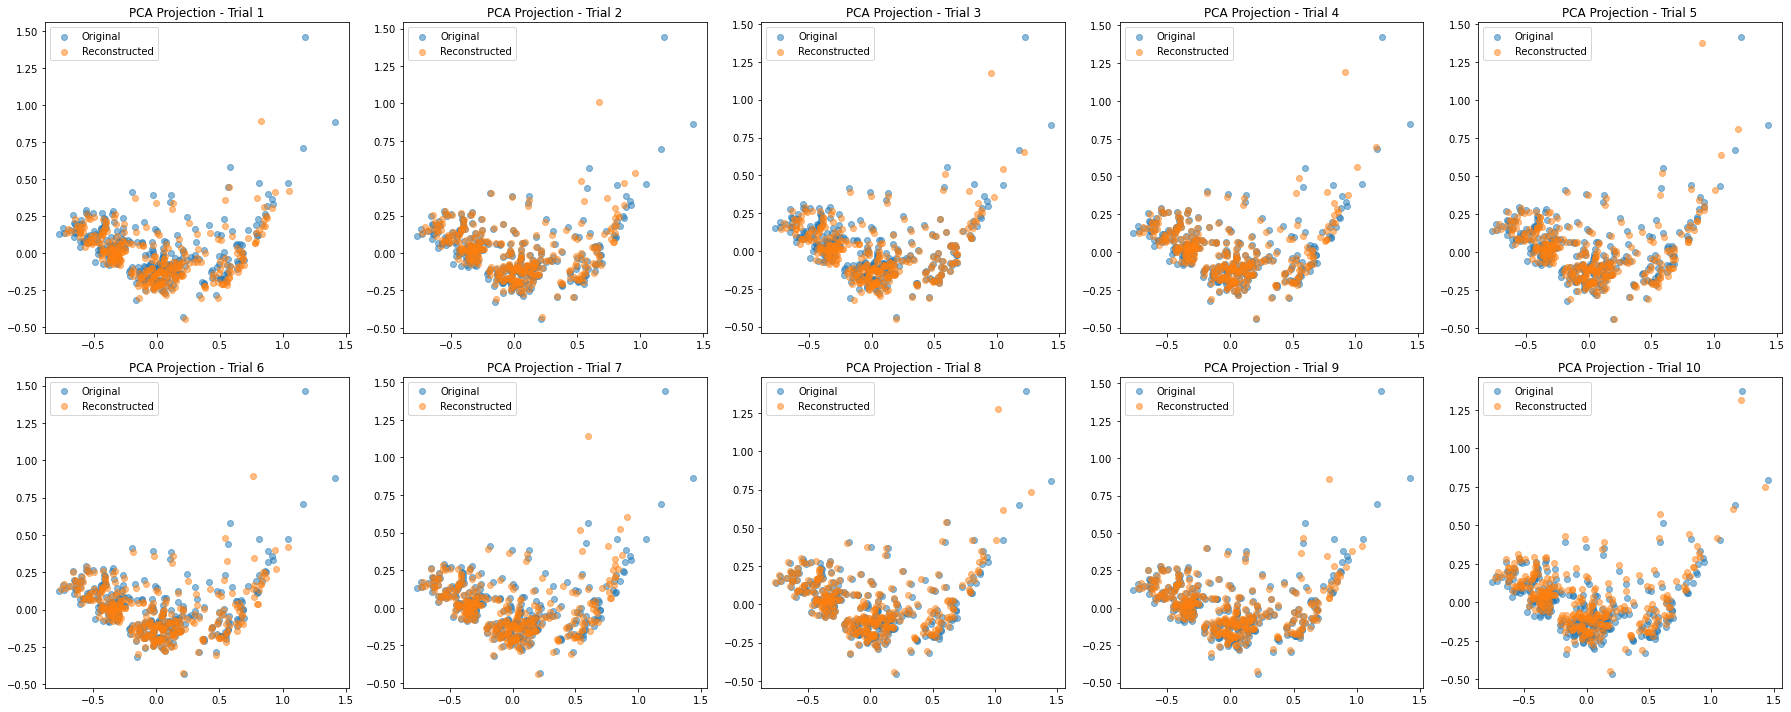

In [21]:
num_trials = 10

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

# Plot PCA Projection
for trial in range(num_trials):
    ax = axes[trial]
    ax.scatter(pca_results[trial][:len(X_test), 0], pca_results[trial][:len(X_test), 1], label="Original", alpha=0.5)
    ax.scatter(pca_results[trial][len(X_test):, 0], pca_results[trial][len(X_test):, 1], label="Reconstructed", alpha=0.5)
    ax.legend()
    ax.set_title(f'PCA Projection - Trial {trial+1}')

# Adjust layout
plt.tight_layout()
plt.show()

In [22]:
count = 1

for result in metrics:
    print(f"Trial {count}")
    count += 1
    print("MSE:", result[0])
    print("MAE:", result[1])
    print("REE:", result[2])
    print("Euclidean Distance:", result[3])
    print()

Trial 1
MSE: 0.00137765438130683
MAE: 0.02325552670167736
REE: 0.03518767540614697
Euclidean Distance: 0.11014840112892241

Trial 2
MSE: 0.0006373857805886266
MAE: 0.015048915345936484
REE: 0.020092010408393958
Euclidean Distance: 0.06285142803216773

Trial 3
MSE: 0.0005378531717864279
MAE: 0.015721840041482693
REE: 0.022199358613136565
Euclidean Distance: 0.0698714135758342

Trial 4
MSE: 0.0006216570521821352
MAE: 0.017133422767020512
REE: 0.023202026630112282
Euclidean Distance: 0.07344438540704053

Trial 5
MSE: 0.0005125231463804996
MAE: 0.01627081483951188
REE: 0.021698275542031412
Euclidean Distance: 0.06836581559076312

Trial 6
MSE: 0.002069959324555895
MAE: 0.030274815394509488
REE: 0.04459741844109051
Euclidean Distance: 0.13941772375820222

Trial 7
MSE: 0.0015895777481561766
MAE: 0.027083116430312842
REE: 0.037403452347175715
Euclidean Distance: 0.11767454062658213

Trial 8
MSE: 0.0028136049358236845
MAE: 0.03923671294828683
REE: 0.0549036168169234
Euclidean Distance: 0.172335

In [23]:
# Calculate statistics for MSE, MAE, REE, and Euclidean error
metrics = np.array(metrics)
mse_mean = np.mean(metrics[:, 0])
mse_std = np.std(metrics[:, 0])
mae_mean = np.mean(metrics[:, 1])
mae_std = np.std(metrics[:, 1])
ree_mean = np.mean(metrics[:, 2])
ree_std = np.std(metrics[:, 2])
euclidean_mean = np.mean(metrics[:, 3])
euclidean_std = np.std(metrics[:, 3])
error_percentages_mean = np.mean([np.mean(error_percentage) for error_percentage in error_percentages])
error_percentages_std = np.std([np.mean(error_percentage) for error_percentage in error_percentages])


# Print statistics for MSE, MAE, REE, and Euclidean error
print("\n===== Additional Metrics Across 10 Trials =====")
print(f"Error Percentage Mean: {error_percentages_mean:.4f}% ± {error_percentages_std:.4f}%")
print(f"MSE Mean: {mse_mean:.4f} ± {mse_std:.4f}")
print(f"MAE Mean: {mae_mean:.4f} ± {mae_std:.4f}")
print(f"REE Mean: {ree_mean:.4f} ± {ree_std:.4f}")
print(f"Euclidean Mean: {euclidean_mean:.4f} ± {euclidean_std:.4f}")


===== Additional Metrics Across 10 Trials =====
Error Percentage Mean: 2.7393% ± 1.0715%
MSE Mean: 0.0015 ± 0.0011
MAE Mean: 0.0256 ± 0.0105
REE Mean: 0.0360 ± 0.0145
Euclidean Mean: 0.1128 ± 0.0452
